[2015-08-27] OSQP failed: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. — trying ECOS
[2015-08-27] ECOS failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver' — trying SCS
[2015-08-27] All solvers failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver'
[2015-08-31] OSQP failed: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. — trying ECOS
[2015-08-31] ECOS failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver' — trying SCS
[2015-08-31] All solvers failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver'
[2015-10-01] OSQP failed: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. — trying ECOS
[2015-10-01] ECOS failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver' — trying SCS
[2015-10-01] All solvers failed: EfficientFrontie

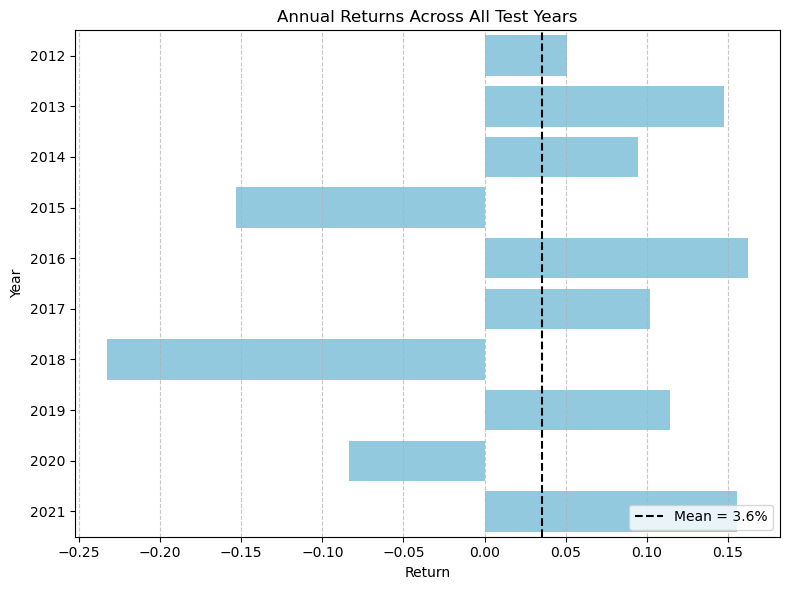

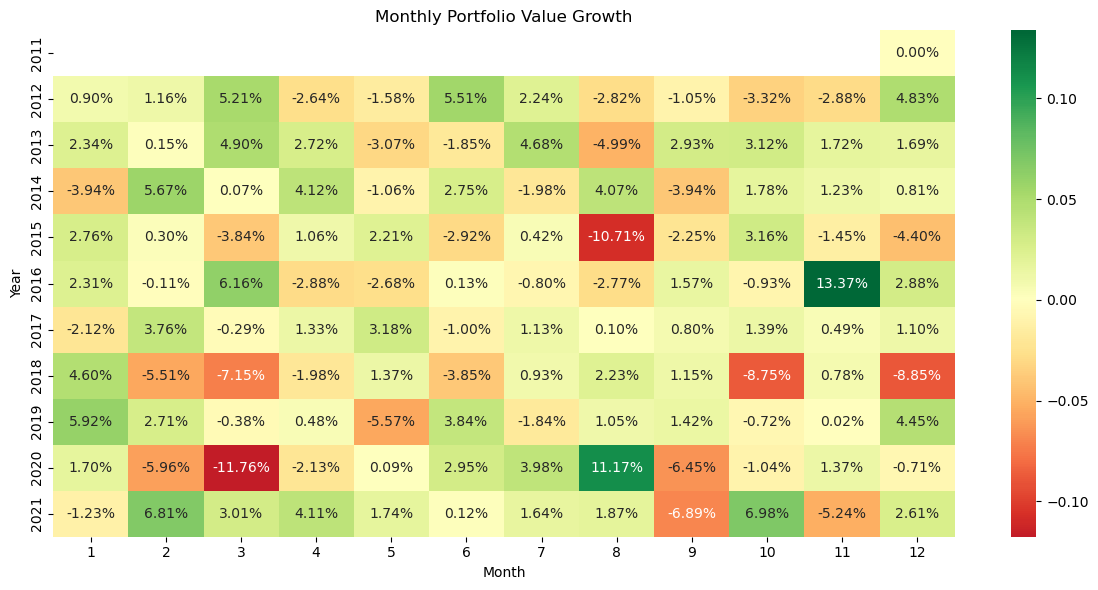

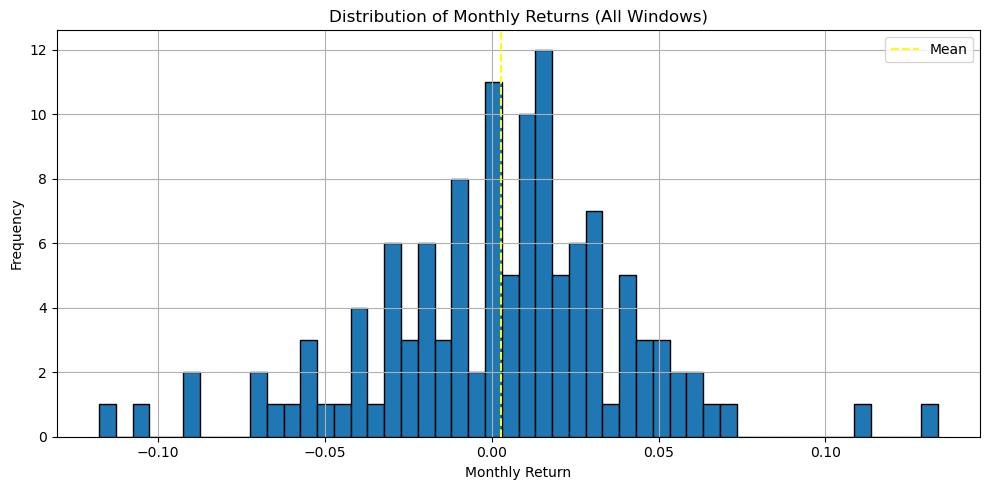

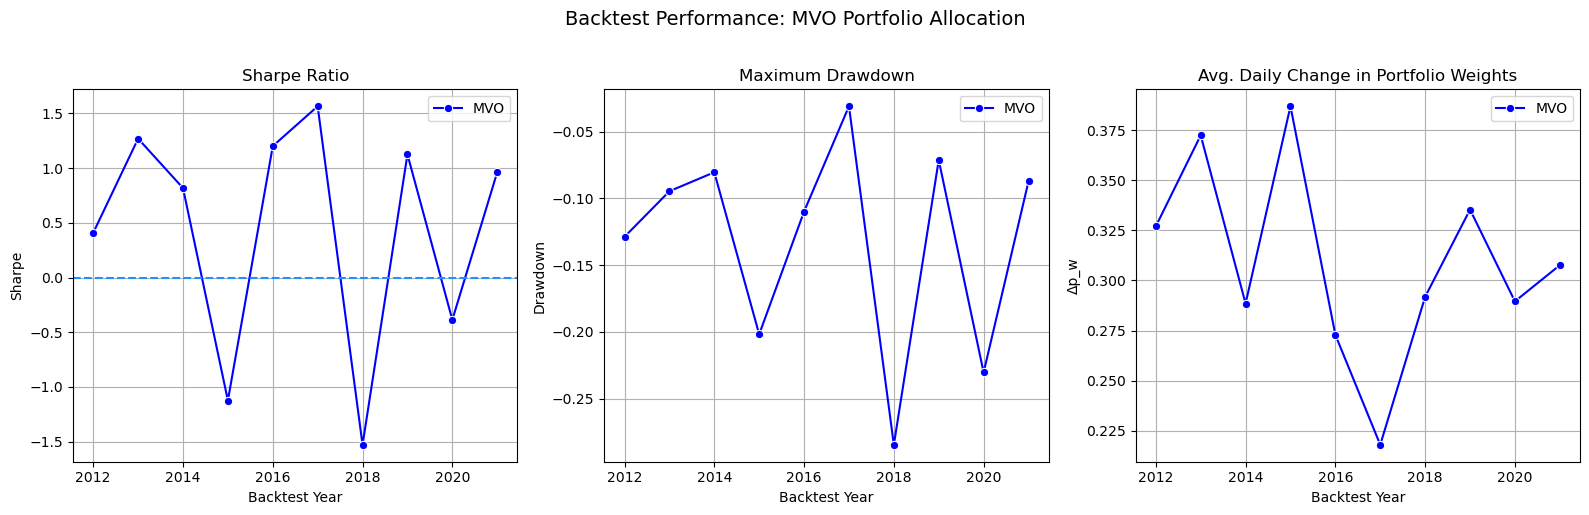

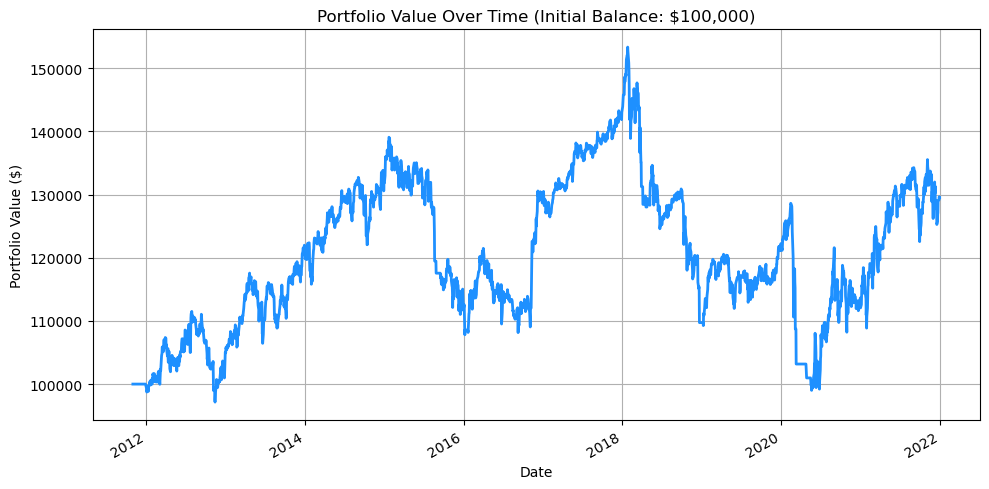

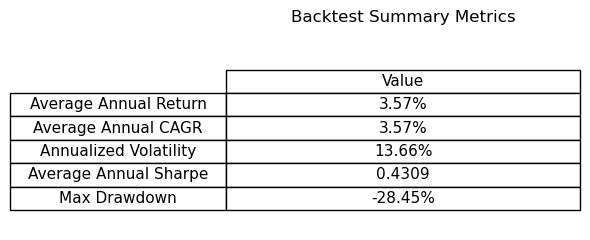

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models
import seaborn as sns

# =========================
# 1. Configuration
# =========================
DATA_PATH    = "/Users/benjaminli/Code/MyTradingProjects/DRL_Portfolio_Optimisation/DRL-Portfolio-Optimisation/data"

# Official backtest period start/end (results recorded from RESULT_START_DATE)
RESULT_START_DATE = "2012-01-01"
END_DATE          = "2021-12-31"
LOOKBACK          = 60   # Rolling window length (days)

# Compute data loading start to include LOOKBACK days prior to RESULT_START_DATE
LOAD_START_DATE = (pd.to_datetime(RESULT_START_DATE) - pd.Timedelta(days=LOOKBACK)).strftime('%Y-%m-%d')

# Sector ETFs (or proxies) and benchmark
SECTOR_ETFS = [
    'SP500-50', 'SP500-25', 'SP500-30', 'SP500-40',
    'SP500-35', 'SP500-20', 'SP500-45', 'SP500-15',
    'SP500-60', 'SP500-55', 'GSPE'
]
BENCHMARK = "GSPC"  # S&P 500 Index

WEIGHT_BOUNDS  = (0, 1)  # Long-only
RISK_FREE_RATE = 0      # For Sharpe calculation

warnings.filterwarnings("ignore")  # suppress pypfopt warnings

# =========================
# 2. Load Price Data (with extended lookback)
# =========================
tickers = SECTOR_ETFS + [BENCHMARK]
prices = pd.DataFrame()


for t in tickers:
    path = os.path.join(DATA_PATH, f"{t}.csv")
    df = pd.read_csv(path, index_col="Date", parse_dates=True)
    prices[t] = df["Adj Close"]

# prices.ffill(inplace=True)
# Interpolate missing values in prices
prices = prices.apply(pd.to_numeric, errors='coerce')
prices = prices.interpolate(method='linear', axis=0)

prices.dropna(how="all", inplace=True)
prices.sort_index(inplace=True)

# convert your string dates to Timestamps
start_ts = pd.to_datetime(LOAD_START_DATE)
end_ts   = pd.to_datetime(END_DATE)

# find the integer positions
idx = prices.index

# left‐bound: first index ≥ start_ts
start_loc = idx.searchsorted(start_ts, side='left')

# right‐bound: first index > end_ts, so we subtract 1 to include end_ts
end_loc   = idx.searchsorted(end_ts,   side='right') - 1

# now slice by integer location
prices = prices.iloc[start_loc : end_loc + 1] \
               .apply(pd.to_numeric, errors="coerce")



# Separate SPY and sector prices
spy_prices    = prices[BENCHMARK].copy()
sector_prices = prices[SECTOR_ETFS].copy()

# =========================
# 3. Helper: Positive Definite Covariance
# =========================
def make_positive_definite(cov, epsilon=1e-4):
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.clip(eigvals, epsilon, None)
    pd_cov = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return (pd_cov + pd_cov.T) / 2

# =========================
# 4. Rolling Optimization
# =========================
daily_weights = {}
daily_sharpe  = {}

for today in sector_prices.index:
    # Only record results from the official backtest period
    if today < pd.to_datetime(RESULT_START_DATE):
        continue

    window = sector_prices.loc[:today].iloc[-LOOKBACK:]
    if window.isnull().any().any() or (window < 0).any().any():
        continue


    # 1) Estimate returns and covariance
    mu      = expected_returns.mean_historical_return(window)
    raw_cov = risk_models.CovarianceShrinkage(window).ledoit_wolf()
    cov     = make_positive_definite(raw_cov)

    # 2) Initialize optimizer
    ef = EfficientFrontier(mu, cov, weight_bounds=WEIGHT_BOUNDS)

    # 3) If no asset beats the risk-free rate, hold cash (zero weights)
    if (mu <= RISK_FREE_RATE).all():
        weights = {ticker: 0.0 for ticker in window.columns}
        ret, vol, sr = 0.0, 0.0, 0.0

    else:
        try:
            ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
        except Exception as e:
            print(f"[{today.date()}] OSQP failed: {e} — trying ECOS")
            try:
                ef.max_sharpe(risk_free_rate=RISK_FREE_RATE, solver="ECOS")
            except Exception as e2:
                print(f"[{today.date()}] ECOS failed: {e2} — trying SCS")
                try:
                    ef.max_sharpe(risk_free_rate=RISK_FREE_RATE, solver="SCS")
                except Exception as e3:
                    print(f"[{today.date()}] All solvers failed: {e3}")
                    weights = {ticker: 0.0 for ticker in window.columns}
                    ret, vol, sr = 0.0, 0.0, 0.0
                    continue  # skip to next date

        weights = ef.clean_weights()
        ret, vol, sr = ef.portfolio_performance(verbose=False)

    # 4) Save results
    daily_weights[today] = pd.Series(weights)
    daily_sharpe[today]  = sr


# Build DataFrame/Series and fill any gaps
weights_df = pd.DataFrame(daily_weights).T.sort_index()
sharpe_sr  = pd.Series(daily_sharpe).sort_index().ffill().bfill()

# =========================
# 5. Portfolio Return Simulation
# =========================
# Next-day returns
asset_rets = sector_prices.pct_change().shift(-1)
# Weighted sum
port_rets  = (weights_df * asset_rets).sum(axis=1).dropna()

# Simulate portfolio value over time
starting_balance = 100_000
cumulative_returns = (1 + port_rets).cumprod()
portfolio_value = cumulative_returns * starting_balance

# =========================
# 6. Annual Metrics
# =========================
annual_rets  = port_rets.resample("Y").apply(lambda r: (1 + r).prod() - 1)
annual_vols  = port_rets.resample("Y").std() * np.sqrt(252)
annual_sharpe   = annual_rets / annual_vols

# Max drawdown per year
def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    drawdown = (cum / peak) - 1
    return drawdown.min()

annual_drawdown = port_rets.resample('Y').apply(max_drawdown)

# Average daily turnover per year
daily_turnover = weights_df.diff().abs().sum(axis=1)
annual_turnover = daily_turnover.resample('Y').mean()

# Assemble into one DataFrame
annual_df = pd.DataFrame({
    'return'   : annual_rets,
    'vol'      : annual_vols,
    'sharpe'   : annual_sharpe,
    'drawdown' : annual_drawdown,
    'turnover' : annual_turnover
})
# Convert the index (Timestamp like 2023-12-31) to a simple Year column
annual_df.index = annual_df.index.year
annual_df.index.name = 'year'
annual_df = annual_df.reset_index()
annual_df = annual_df[annual_df['year'] != 2011].reset_index(drop=True)



# Monthly returns series
combined_monthly = port_rets.resample('M').apply(lambda r: (1 + r).prod() - 1)

# --- 2') Annual Return Horizontal Bar Plot ---
plt.figure(figsize=(8, 6))
sns.barplot(
    y="year",
    x="return",
    data=annual_df,
    color="skyblue",
    orient="h"          # horizontal orientation
)
# mean line now vertical at the mean return
mean_ret = annual_df['return'].mean()
plt.axvline(mean_ret, color='black', linestyle='--', label=f'Mean = {mean_ret:.1%}')

plt.title("Annual Returns Across All Test Years")
plt.xlabel("Return")
plt.ylabel("Year")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("./backtest_results/mvo_combined_annual_returns_horizontal.png")
plt.show()

# --- 3) Monthly Heatmap ---
# Recompute monthly portfolio values
monthly_value = portfolio_value.resample('M').last()
monthly_growth = monthly_value.pct_change()

# Add year and month
heatmap_value = monthly_growth.to_frame(name="growth")
heatmap_value['Year']  = heatmap_value.index.year
heatmap_value['Month'] = heatmap_value.index.month
pivot_growth = heatmap_value.pivot(index="Year", columns="Month", values="growth")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_growth, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title("Monthly Portfolio Value Growth")
plt.tight_layout()
plt.savefig("./backtest_results/mvo_portfolio_growth_heatmap.png")
plt.show()


# --- 4) Monthly Return Distribution ---
plt.figure(figsize=(10, 5))
combined_monthly.hist(bins=50, edgecolor='black')
plt.axvline(combined_monthly.mean(), color='yellow', linestyle='--', label='Mean')
plt.title("Distribution of Monthly Returns (All Windows)")
plt.xlabel("Monthly Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./backtest_results/mvo_combined_monthly_distribution.png")
plt.show()

# --- 5) DRL Metrics Line Plots ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Sharpe
sns.lineplot(ax=axes[0], x="year", y="sharpe", data=annual_df, marker="o",
             color="blue", label="MVO")
axes[0].axhline(0, linestyle="--", color="dodgerblue")
axes[0].set_title("Sharpe Ratio")
axes[0].set_ylabel("Sharpe")
axes[0].set_xlabel("Backtest Year")
axes[0].grid(True)

# Drawdown
sns.lineplot(ax=axes[1], x="year", y="drawdown", data=annual_df, marker="o",
             color="blue", label="MVO")
axes[1].set_title("Maximum Drawdown")
axes[1].set_ylabel("Drawdown")
axes[1].set_xlabel("Backtest Year")
axes[1].grid(True)

# Turnover
sns.lineplot(ax=axes[2], x="year", y="turnover", data=annual_df, marker="o",
             color="blue", label="MVO")
axes[2].set_title("Avg. Daily Change in Portfolio Weights")
axes[2].set_ylabel("Δp_w")
axes[2].set_xlabel("Backtest Year")
axes[2].grid(True)

plt.suptitle("Backtest Performance: MVO Portfolio Allocation", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("./backtest_results/backtest_mvo_metrics.png")
plt.show()


plt.figure(figsize=(10, 5))
portfolio_value.plot(color="dodgerblue", linewidth=2)
plt.title("Portfolio Value Over Time (Initial Balance: $100,000)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.savefig("./backtest_results/mvo_portfolio_value_over_time.png")
plt.show()

# =========================
# 7. Summary Metrics
# =========================

avg_annual_return = annual_df['return'].mean()
avg_annual_sharpe   = annual_df['sharpe'].mean()
avg_annual_cagr     = annual_df['return'].mean()
volatility   = port_rets.std() * np.sqrt(252)
the_max_drawdown = annual_drawdown.min()

# print(f"Average Annual Return: {avg_annual_return:.2%}")
# print(f"Average Annual CAGR:        {avg_annual_cagr:.2%}")
# print(f"Annualized Volatility:        {volatility:.2%}")
# print(f"Average Annual Sharpe:    {avg_annual_sharpe:.4f}")
# print(f"Max Drawdown: {the_max_drawdown:.2%}")

# 1) Build a small DataFrame of formatted values
metrics = pd.DataFrame({
    'Metric': [
        'Average Annual Return',
        'Average Annual CAGR',
        'Annualized Volatility',
        'Average Annual Sharpe',
        'Max Drawdown'
    ],
    'Value': [
        f"{avg_annual_return:.2%}",
        f"{avg_annual_cagr:.2%}",
        f"{volatility:.2%}",
        f"{avg_annual_sharpe:.4f}",
        f"{the_max_drawdown:.2%}"
    ]
})

# 2) Plot it as a Matplotlib table
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis('off')  # no axes

# Create the table: one column of Values, rows = Metric names
table = ax.table(
    cellText=metrics[['Value']].values,
    rowLabels=metrics['Metric'],
    colLabels=['Value'],
    cellLoc='center',
    rowLoc='center',
    loc='center'
)

# Tweak appearance
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.5)  # cell width, height multiplier

plt.title("Backtest Summary Metrics", pad=20)
plt.tight_layout()
plt.show()


In [7]:
# make sure output folder exists
os.makedirs("./backtest_results", exist_ok=True)

# 1) Monthly returns (as a one‑column frame)
combined_monthly.to_frame(name="return") \
    .to_csv("./backtest_results/combined_monthly_mvo.csv", index=True)

# 2) Annual metrics
annual_df.to_csv("./backtest_results/annual_metrics_mvo.csv", index=False)

# 3) Daily portfolio value
portfolio_value.to_frame(name="portfolio_value") \
    .to_csv("./backtest_results/portfolio_value_mvo.csv", index=True)

# 4) Summary table
metrics.to_csv("./backtest_results/summary_metrics_mvo.csv", index=False)
